In [1]:
%load_ext autoreload
%autoreload 2
# %load_ext wurlitzer
%matplotlib ipympl

import numpy as np
import xobjects as xo
from xcoll.scattering_routines.geometry.segments import *
from xcoll.scattering_routines.geometry.c_init import *
from xcoll.scattering_routines.geometry.trajectories import get_max_crossings

import xcoll as xc

import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
context = xo.ContextCpu()

context.add_kernels(
    kernels={
        "Segments_crossing_drift": xo.Kernel(
            c_name="Segments_crossing_drift",
            args=[
                xo.Arg(Segments,   name="segs"),
                xo.Arg(xo.Int8,    pointer=True, name="n_hit"),
                xo.Arg(xo.Float64, pointer=True,  name="s"),
                xo.Arg(xo.Float64, pointer=False, name="s0"),
                xo.Arg(xo.Float64, pointer=False, name="x0"),
                xo.Arg(xo.Float64, pointer=False, name="m")
            ],
            ret=None,
        )
    }, save_source_as="temp.c"
)

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [3]:
def check_segments_drift(segs, plot_object=False, xlim=(-0.5, 1.5), ylim=(-0.5, 1.5)):
    to_remove = []
    s_val = np.linspace(*xlim, 200)
    fig, ax = plt.subplots(1, 1, figsize=(8,8))
    if plot_object:
        t = np.linspace(-4, 4, 4000)
        ax.scatter(*segs.evaluate(t), s=1)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect('equal')

    n_hit = np.zeros(1, dtype=np.int8)
    s = np.zeros(get_max_crossings(segs, "drift"), dtype=np.float64)
    # s = np.zeros(8, dtype=np.float64)

    def update_plot(s0, x0, part_theta):
        # Clean the previous trajectory and points
        while to_remove:
            last_point = to_remove.pop()  # Get the last added point
            last_point.remove()
        m = np.tan(np.radians(part_theta))
        # Draw drift trajectory and point
        spread = 10 # degrees
        line, = ax.plot(s_val, m*(s_val - s0) + x0, c='k')
        to_remove.append(line)
        scatter = ax.scatter(s0, x0, c='r', s=20)
        to_remove.append(scatter)
        m1 = np.tan(np.radians(part_theta+spread))
        m2 = np.tan(np.radians(part_theta-spread))
        line = ax.fill_between(s_val, m1*(s_val - s0) + x0, m2*(s_val - s0) + x0, alpha=0.2)
        to_remove.append(line)
        # Create hits for different slopes (small cone around the trajectory)
        hits_s = []
        hits_x = []
        for sp in np.linspace(-spread, spread, 100):
            n_hit[0] = 0
            m = np.tan(np.radians(part_theta + sp))
            context.kernels.Segments_crossing_drift(segs=segs, n_hit=n_hit, s=s, s0=s0, x0=x0, m=m)
            hits_s += list(s[:n_hit[0]])
            hits_x += list(x0 + m*(s[:n_hit[0]] - s0))
        # for i in range(n_hit[0]):
        scatter = ax.scatter(hits_s, hits_x, c='g', s=5)
        # to_remove.append(scatter)
        fig.canvas.draw()  # Redraw the canvas to show the new point


    def onclick(event):
        s0, x0 = event.xdata, event.ydata
        if s0 is not None and x0 is not None:  # Ensure the click is inside the plot
            update_plot(s0, x0, part_theta_slider.value)


    fig.canvas.mpl_connect('button_press_event', onclick)
    part_theta_slider = widgets.IntSlider(min=-89, max=89, step=1, value=0)

    @interact(part_theta=part_theta_slider)
    def check_linesegments(part_theta):
        if to_remove:
            scatter = to_remove[1]  # The second point is the clicked scatter point
            s0, x0 = scatter.get_offsets()[0, 0], scatter.get_offsets()[0, 1]

            # Update the plot with the new slope based on the slider
            update_plot(s0, x0, part_theta)

# plt.show()

# check_linesegments()

In [4]:
this_box = Segments([LineSegment(s1=0, x1=0, s2=0.2, x2=1), LineSegment(s1=0.2, x1=1, s2=1, x2=1),
                     LineSegment(s1=1, x1=1, s2=0.8, x2=0), LineSegment(s1=0.8, x1=0, s2=0, x2=0)])

4


In [8]:
this_box

Segments([LineSegment(...), LineSegment(...), LineSegment(...), LineSegment(...)])

In [13]:
this_box._extra_c_sources

['\n/*gpufun*/\nvoid Segments_crossing_drift(Segments segs, int8_t* n_hit, double* s, double s0, double x0, double m){\n    int64_t n_segments = Segments_len_data(segs);\n    for (int8_t i=0; i<n_segments;i++) {\n        Segment seg = Segments_getp1_data(segs, i);\n        Segment_crossing_drift(seg, n_hit, s, s0, x0, m);\n    }\n    sort_array_of_double(s, (int64_t) *n_hit);\n}\n',
 '\n/*gpufun*/\nvoid Segments_crossing_drift_vlimit(Segments segs, int8_t* n_hit, double* s, double s0, double x0, double m){\n    int64_t n_segments = Segments_len_data(segs);\n    for (int8_t i=0; i<n_segments;i++) {\n        Segment seg = Segments_getp1_data(segs, i);\n        Segment_crossing_drift(seg, n_hit, s, s0, x0, m);\n    }\n    sort_array_of_double(s, (int64_t) *n_hit);\n}\n']

4


interactive(children=(IntSlider(value=0, description='part_theta', max=89, min=-89), Output()), _dom_classes=(…

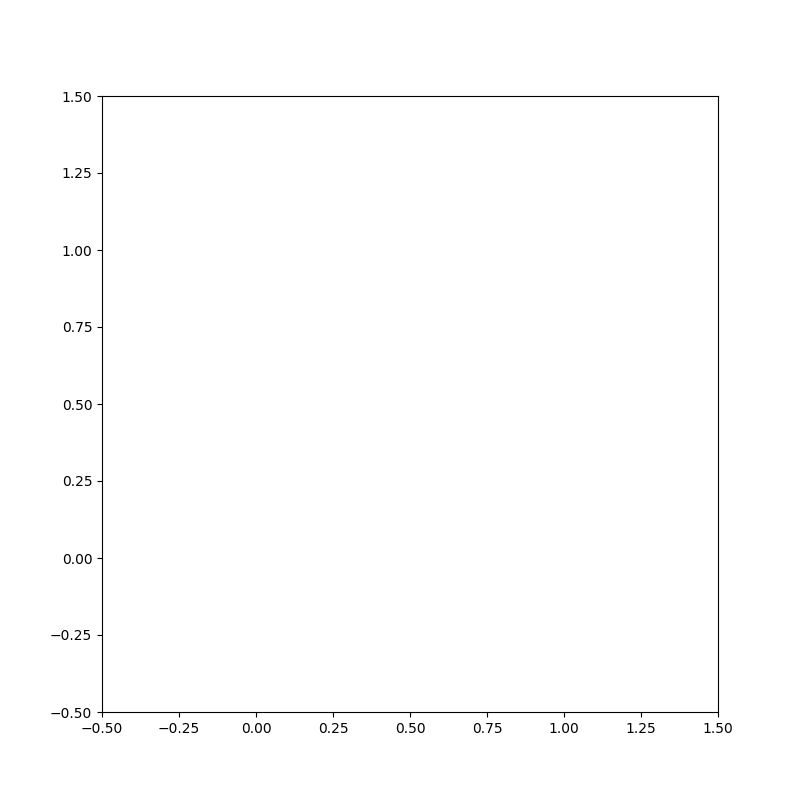

In [6]:
this_box = Segments(data=[LineSegment(s1=0, x1=0, s2=0.2, x2=1), LineSegment(s1=0.2, x1=1, s2=1, x2=1),
                          LineSegment(s1=1, x1=1, s2=0.8, x2=0), LineSegment(s1=0.8, x1=0, s2=0, x2=0)])

check_segments_drift(this_box, plot_object=False)

interactive(children=(IntSlider(value=0, description='part_theta', max=89, min=-89), Output()), _dom_classes=(…

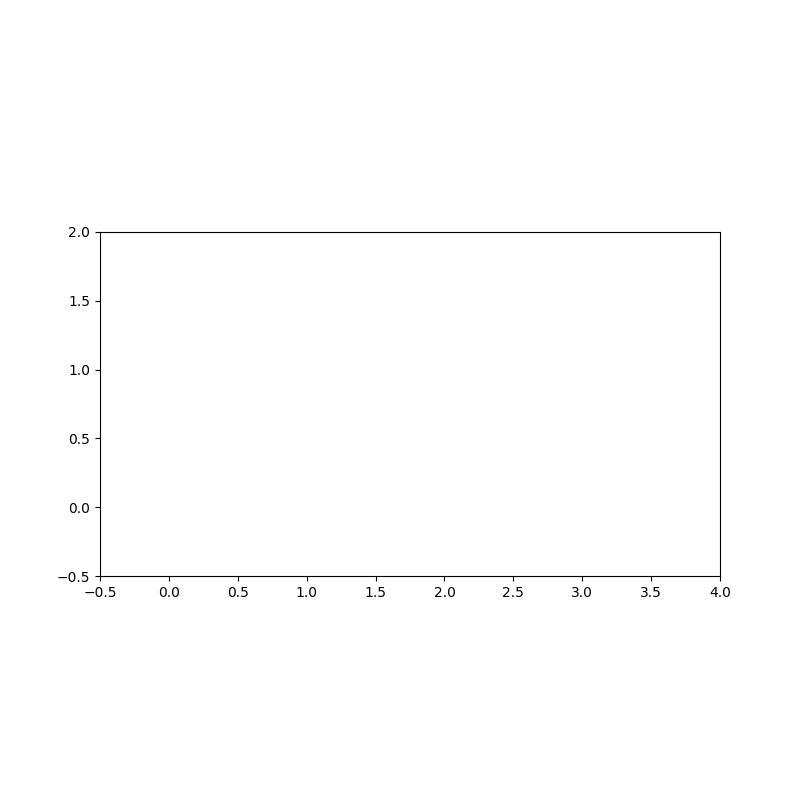

In [5]:
this_box_2 = Segments(data=[LineSegment(s1=0, x1=0, s2=0.2, x2=1),
                            BezierSegment(s1=0.2, x1=1, s2=1+0.5*np.cos(3*np.pi/4), x2=0.5+0.5*np.sin(3*np.pi/4), cs1=0.5, cx1=2.5, cs2=1+0.5*np.cos(3*np.pi/4)-0.6, cx2=0.5+0.5*np.sin(3*np.pi/4)-0.6),
                            CircularSegment(R=0.5, s=1, x=0.5, t1=-np.pi/2, t2=3*np.pi/4),
                            LineSegment(s1=1, x1=0, s2=0, x2=0),
                            HalfOpenLineSegment(s=2, x=1, t=np.pi/4),
                            LineSegment(s1=2, x1=1, s2=3, x2=0),
                            HalfOpenLineSegment(s=3, x=0, t=np.pi/4)])
check_segments_drift(this_box_2, xlim=(-0.5, 4), ylim=(-0.5,2), plot_object=False)

interactive(children=(IntSlider(value=0, description='part_theta', max=89, min=-89), Output()), _dom_classes=(…

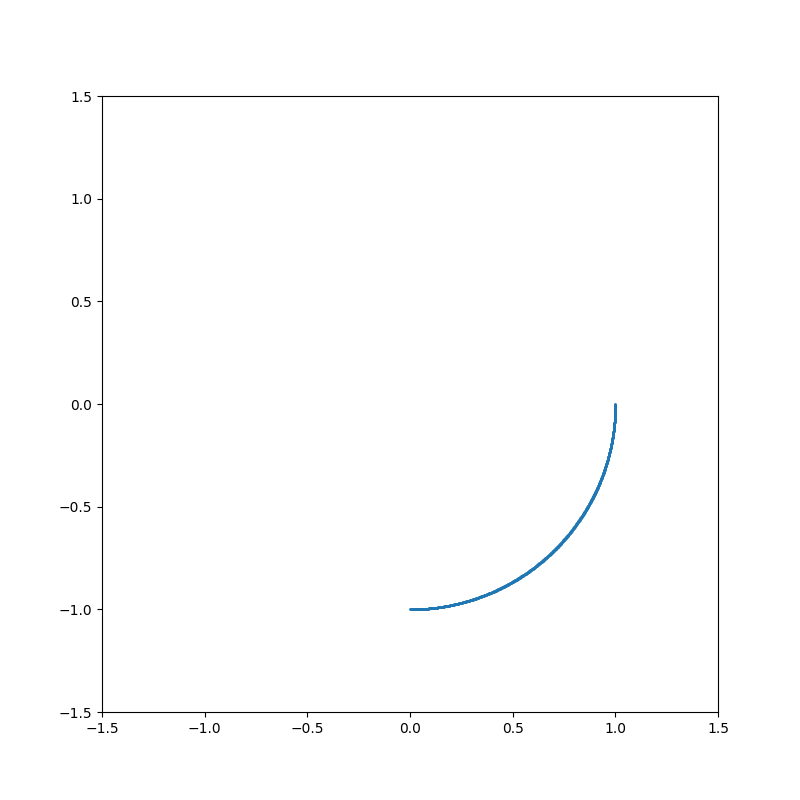

In [6]:
seg = CircularSegment(R=1, s=0., x=0., t1=0,        t2=np.pi/2)
seg = CircularSegment(R=1, s=0., x=0., t1=-np.pi/2, t2=np.pi/2)
seg = CircularSegment(R=1, s=0., x=0., t1=np.pi/2,  t2=-np.pi/2)
seg = CircularSegment(R=1, s=0., x=0., t1=0,        t2=3*np.pi/2)
seg = CircularSegment(R=1, s=0., x=0., t1=0,        t2=2*np.pi)
seg = CircularSegment(R=1, s=0., x=0., t1=0,        t2=-np.pi/2)
seg = CircularSegment(R=1, s=0., x=0., t1=-np.pi/2, t2=0)
seg = CircularSegment(R=1, s=0., x=0., t1=3*np.pi/2,t2=0)

check_segments_drift(Segments(data=[seg]), plot_object=True, xlim=(-1.5, 1.5), ylim=(-1.5, 1.5))